## Fit a DelayedSaturatedMMM with TVP
There are many ways to use time-varying parameters in an MMM. Here are some things one might want to do with TVP in MMM:

1) Time-varying intercept.
   
2) Single time-varying parameter that models a time-varying factor which modulates total effect of media spend. Like `mu = media_contribution.sum(-1) * time_varying_factor + ...`.

3) Each (or selected) channel `beta`s are modulated by seperate time-varying coefficients. This is the most flexible and general approach, and probably the most desired out there, but it's also somewhat unweildy and can very easily overfit to noise. The best approach when doing this is to have a hierarchical hyperprior (and we won't get into that here).

4) ... and niether are mutually exclusive (for technical reasons at least).

☝️ In this notebook, we demonstrate the use of a **time-varying interecept**. Under the hood, it is modeled as a Gaussian Process (specifically a parametric approximation of a GP, see [pymc.gp.HSGP](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html)), centered to have mean 1 and then multiplied by a *baseline intercept*. See the implementation of `DelayedSaturatedMMM` for concrete structural details.

We will run two pretty simple scenarios:

1) The intercept is a yearly seasonal cosine function. Normally, one would use a Fourier basis to model this, but for example sake we will use a time varying intercept to model this.
   
2) The intercept is a linearly increasing function. This is a simple example to show how the model can capture a trend.

In [1]:
import warnings

import arviz as az
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

In [2]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Load some synthetic data

For this example, we're just loading some simulated consumer goods marketing spend/control data.

#### → Load input and define columns

In [3]:
data = pd.read_csv("mock_cgp_data-no-target.csv", parse_dates=["Weeks"])

# Define which columns are media and control
coords = {
    "media": ["Google Search", "DV360", "Facebook", "AMS", "TV", "VOD", "OOH", "Radio"],
    "control": ["Numeric Distribution", "RSP", "Promotion"],
    "week": data["Weeks"],
}

data.head()

Weeks  Google Search     DV360  Facebook       AMS         TV  \
0 2020-01-06       2.414281  3.179336  2.112389  1.326498  13.974318   
1 2020-01-13       1.953829  3.712402  1.122114  0.841185   8.097841   
2 2020-01-20       1.445275  6.610630  3.793022  0.885655  11.670006   
3 2020-01-27       3.695156  2.694912  2.016691  1.130929   9.872921   
4 2020-02-03       1.909138  3.047636  1.887042  1.478925   7.598348   

        VOD       OOH     Radio  Numeric Distribution       RSP  Promotion  
0  1.544316  4.754408  0.000000              0.741301  3.643304   0.969624  
1  1.458398  5.536986  0.000000              0.701279  3.643304   0.853508  
2  2.742102  0.000000  0.854066              0.712682  3.643304   0.974842  
3  4.760902  0.000000  0.963224              0.718657  3.643304   1.000000  
4  2.926870  0.000000  1.475399              0.713845  3.643304   0.937466

<Axes: xlabel='Weeks'>

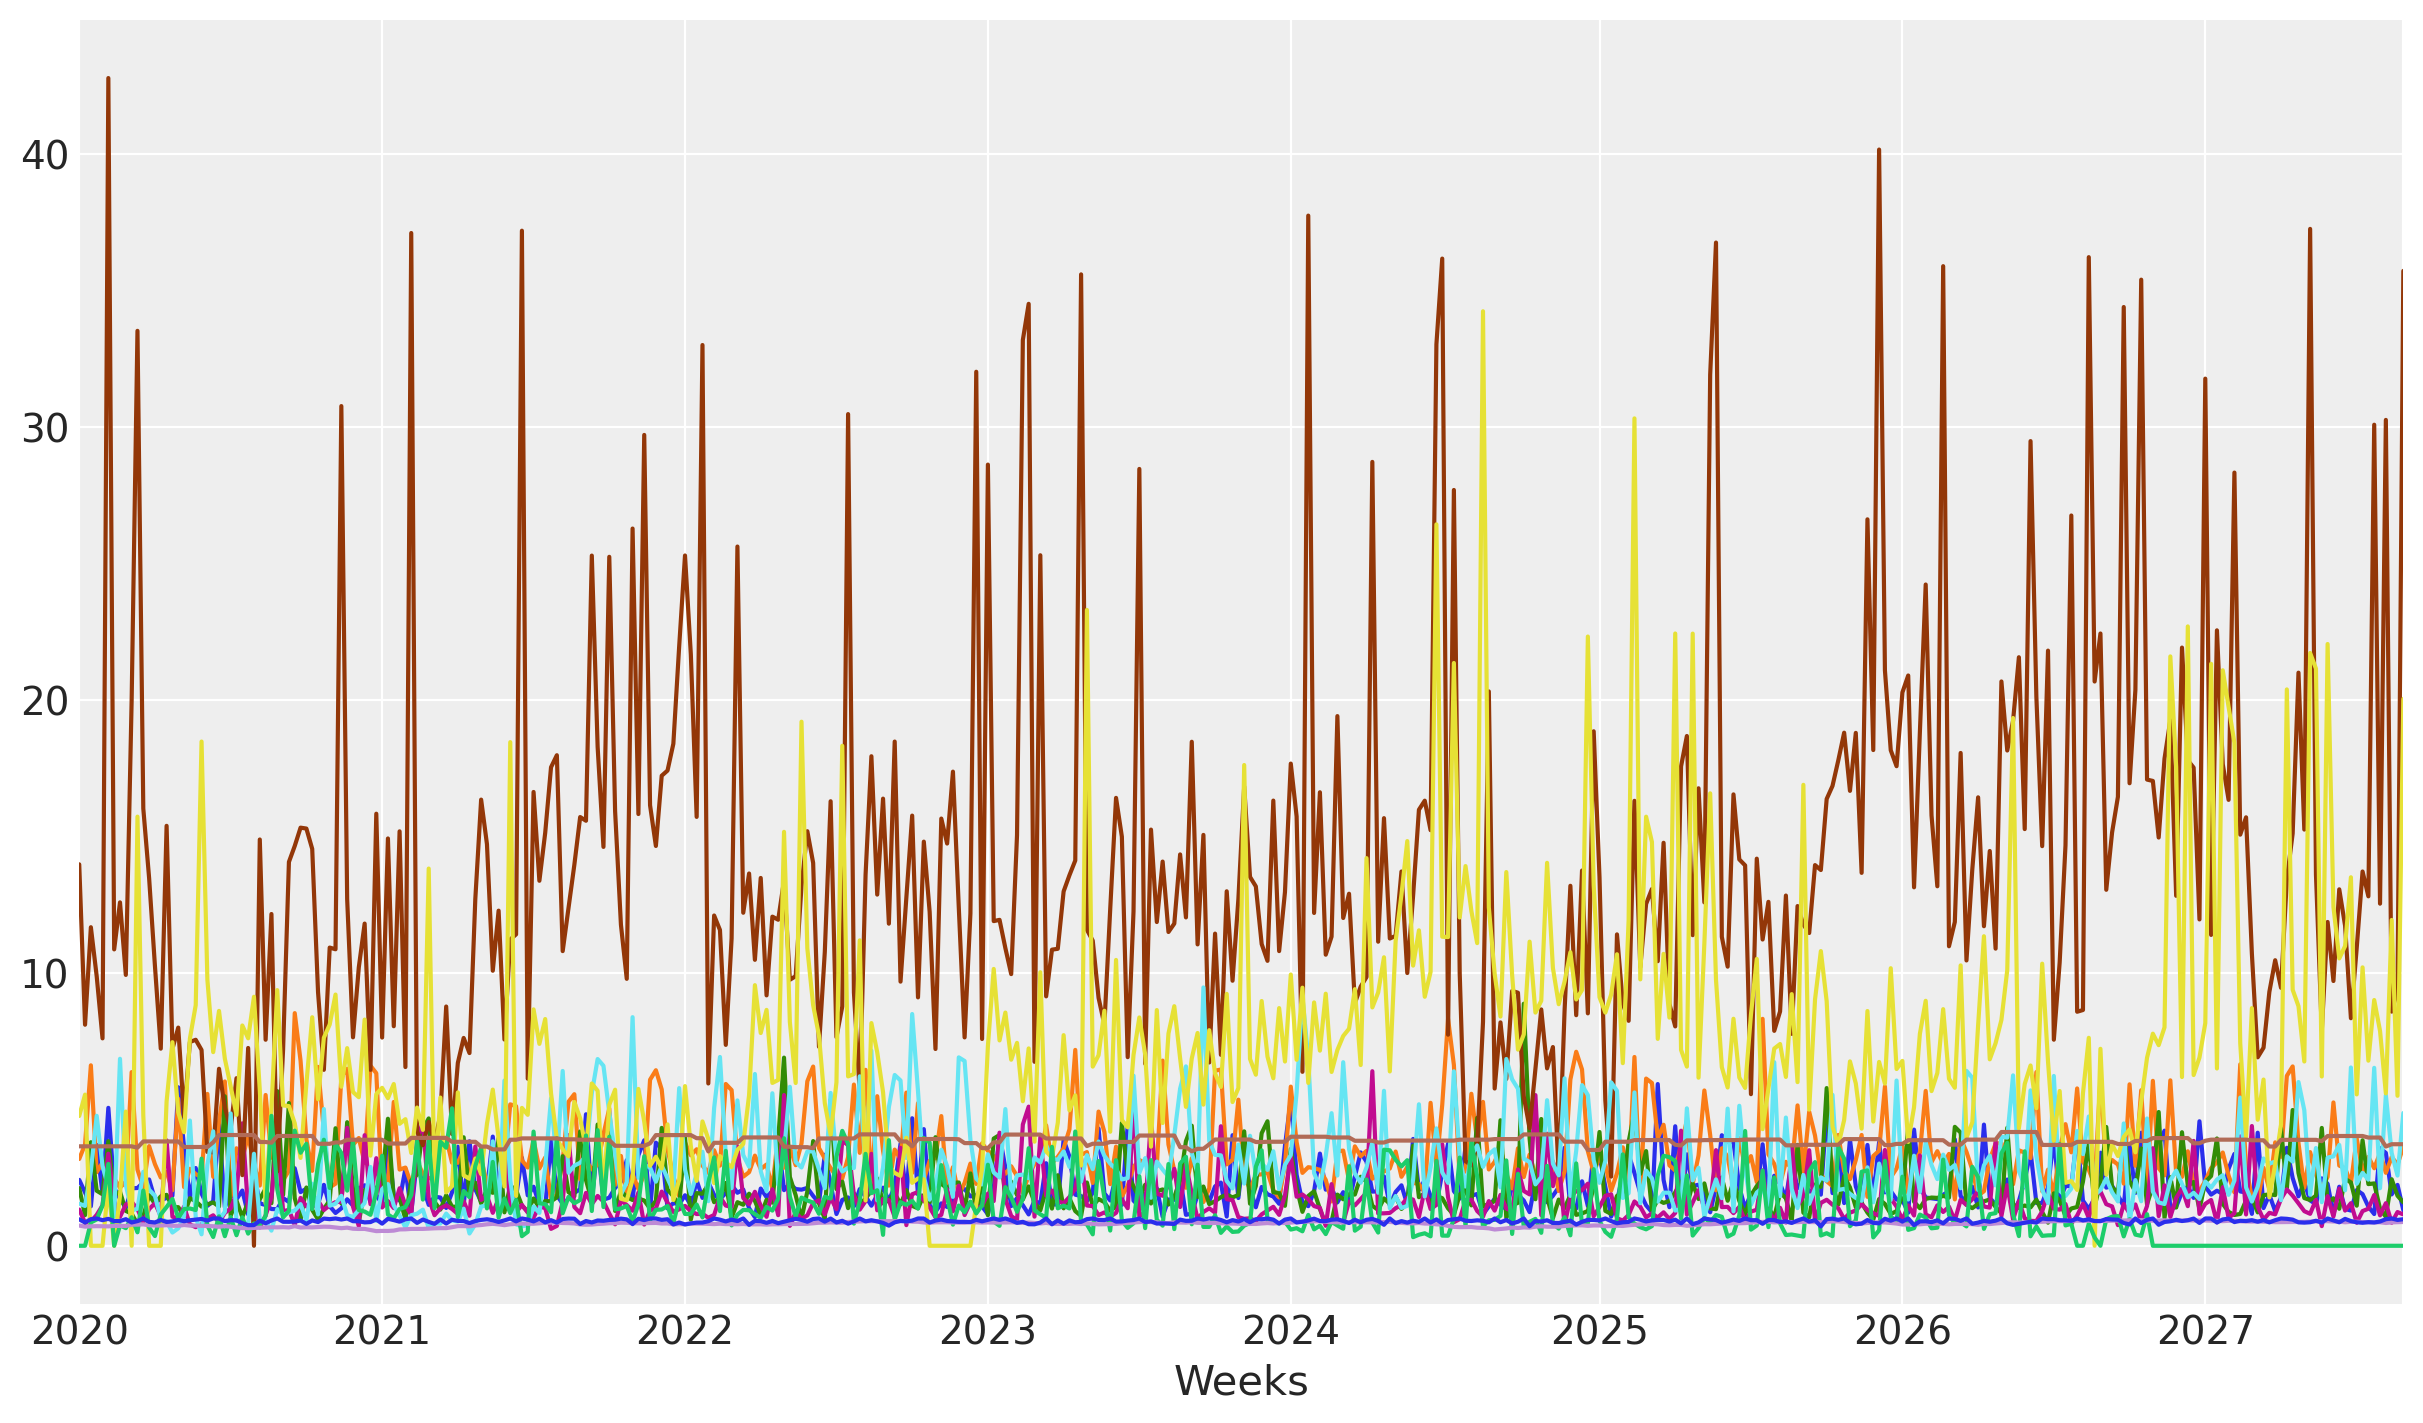

In [4]:
data.set_index('Weeks').plot(legend=False)

## 1. Seasonal intercept

#### → Simulate a target (e.g. sales)

The data we loaded did *not* have a target variable. Instead, we will simulate one, but **defining a model with fixed parameters**. This is something we can do using [the recently added `do` operator](https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/) in `pymc`. If you haven't seen this trick before, take notes because it's quite powerful.

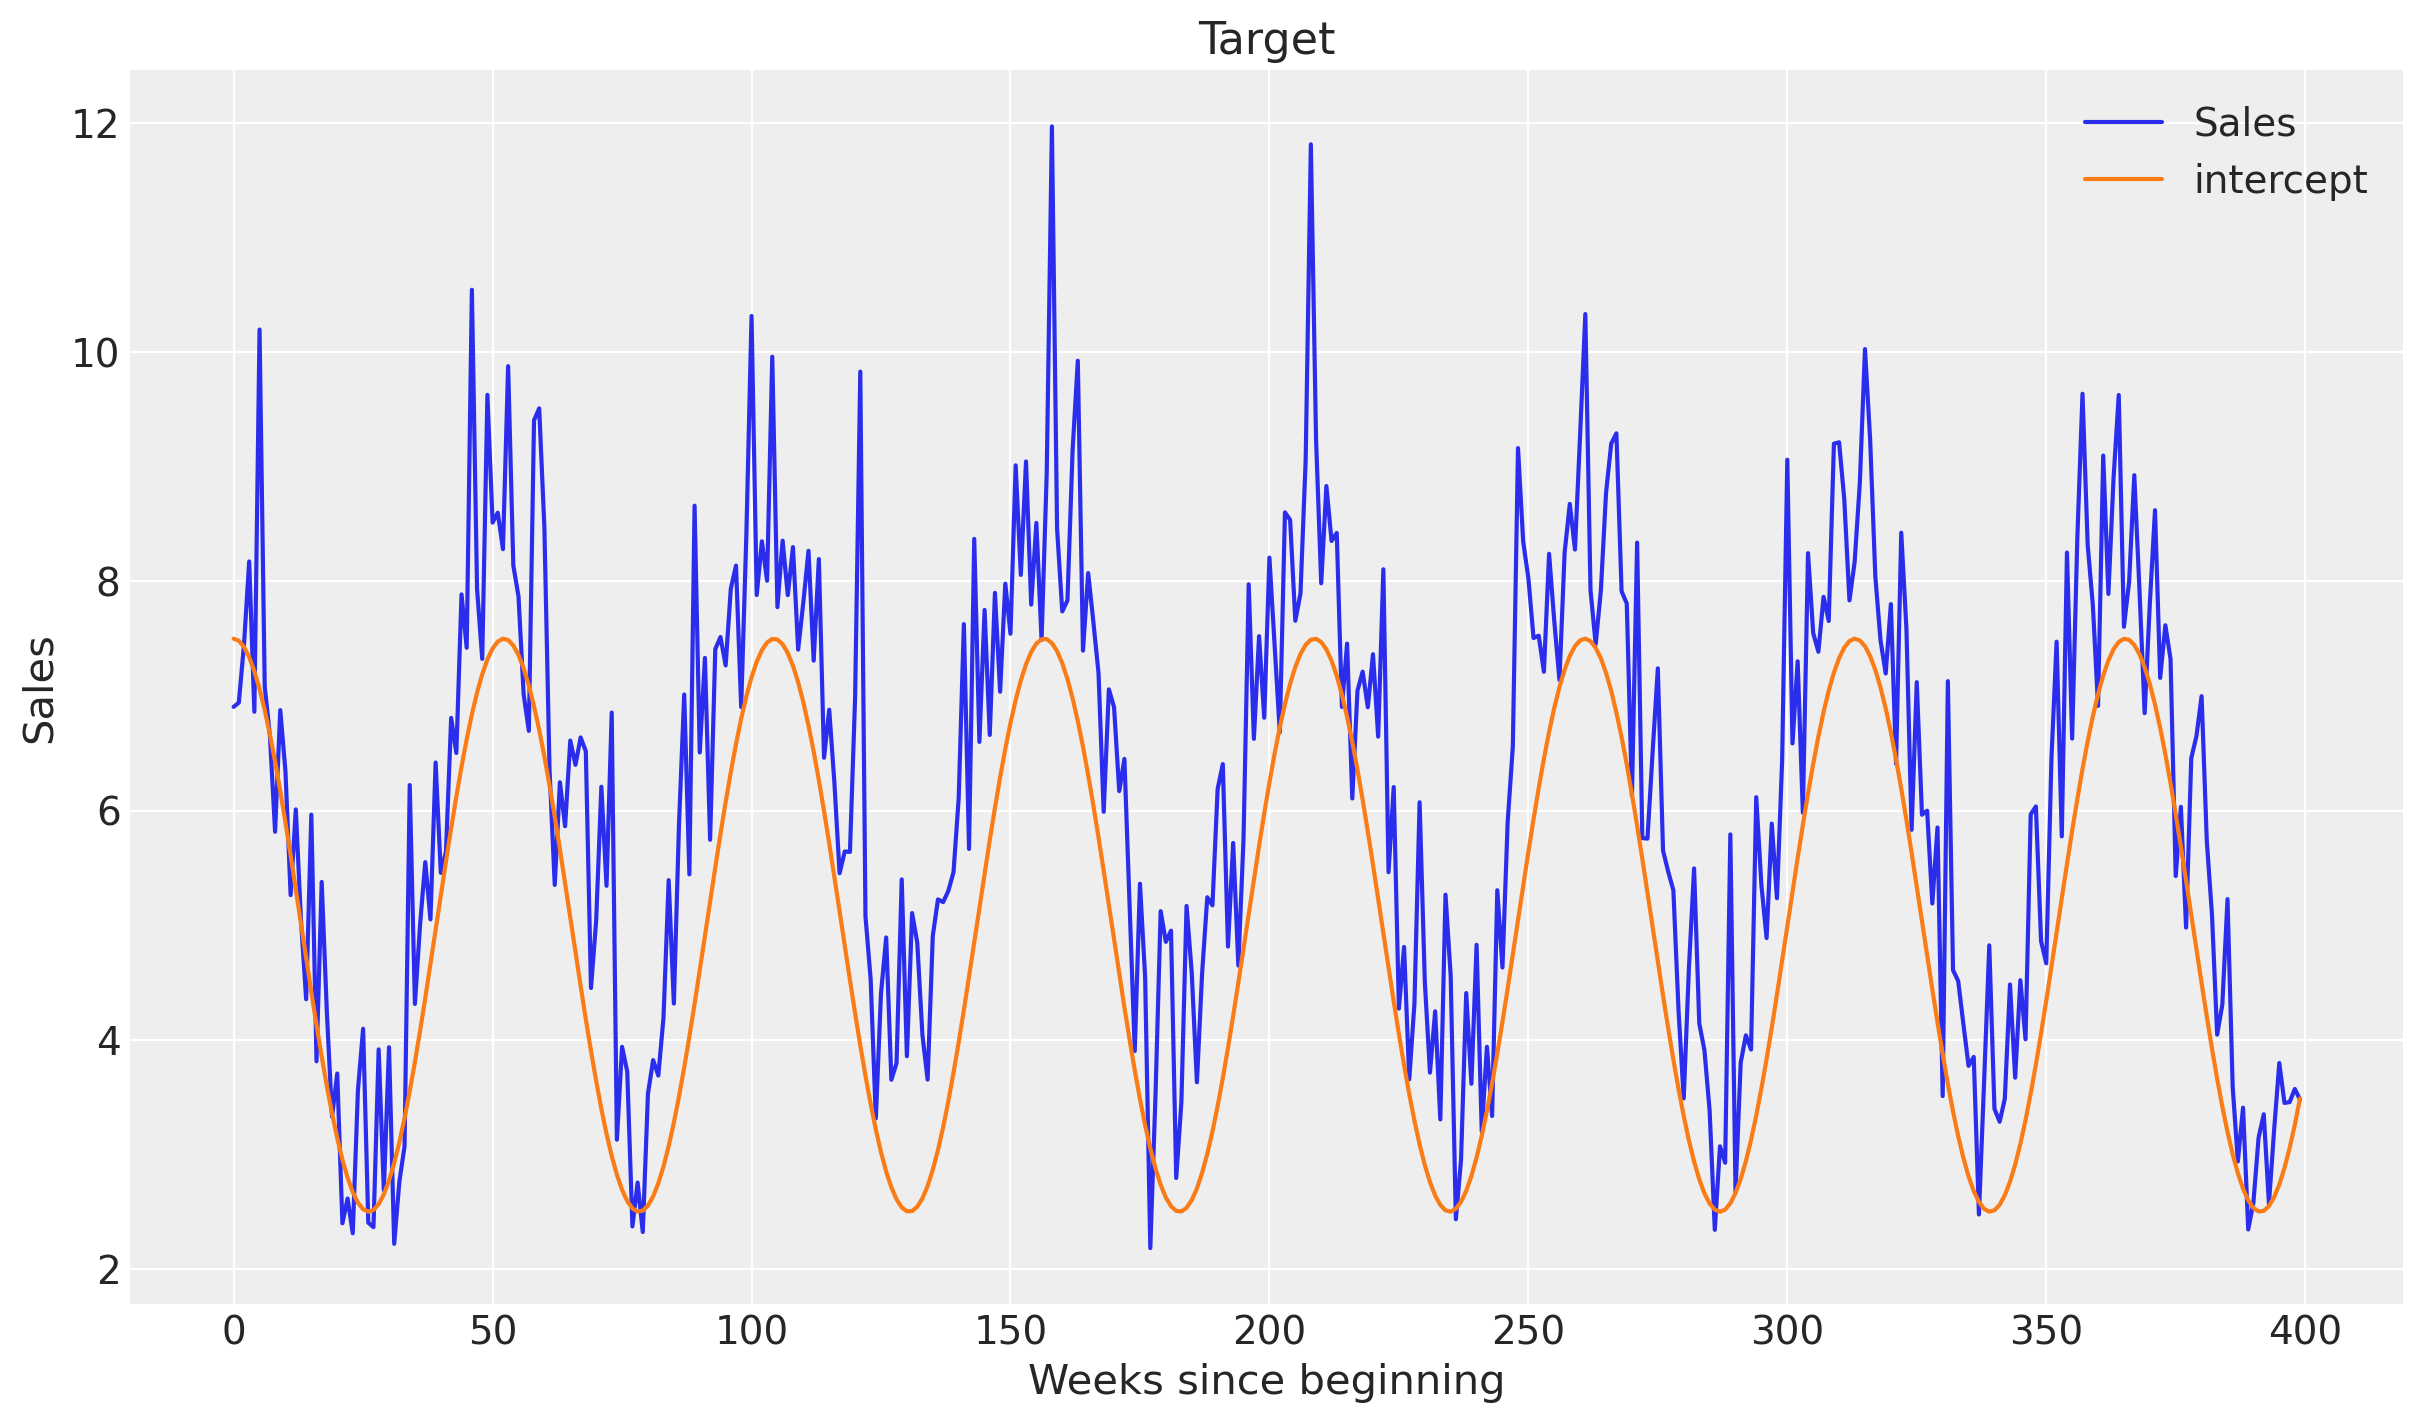

In [5]:
# Create the model, with channel spend, control variables, adstock, and yearly seasonality.
# This model is **structurally identical** to the model we will fit a couple cells below.
mmm_synth1 = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=coords["media"],
    control_columns=coords["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
)

mmm_synth1.build_model(data, np.ones(data.shape[0]))

# Define the true parameters of the model. These are largely arbitrary, though chosen to
# be somewhat realistic. Note that `intercept` is an array. Specifically, we fix the intercept
# to be a cosine wave with a period of 52.18 weeks (1 year) which oscilates around 5. It thus
# mimics yearly seasonality, frequently observed in consumer goods sales data.
N = np.arange(data.shape[0])
true_intercept = (np.cos(2 * np.pi / 52.18 * N) / 2 + 1) * 5
true_params = {
    "intercept": true_intercept,
    "beta_channel": np.array([3.5, 2.0, 5.0, 3.2, 1.5, 2.0, 1.0, 1.5]) * 4,
    "alpha": np.array([0, 0.5, 0.1, 0.1, 0.9, 0.5, 0.9, 0.95]),
    "lam": 1 / (data[coords["media"]].mean(0)).values,
    "likelihood_sigma": 0.25,
}

# Manually set the model parameters. The `do` operator returns a new model where the parameters
# which were supplied are deterministic.
true_model1 = pm.do(
    mmm_synth1.model,
    true_params,
)

# Plot the simulated target series
fig, ax = plt.subplots()
ax.set_title("Target")
data["target1"] = pm.draw(true_model1.y)
data["target1"].plot(xlabel="Weeks since beginning", ylabel="Sales", label="Sales")
ax.plot(true_intercept, label="intercept")
ax.legend()
plt.show()

#### → Split into train and test
We split the data into *train* and *test* sets, so that we can later display out-of-sample predictive performance.

In [6]:
# Split into train and test
data_train = data.iloc[:-52]
data_test = data.iloc[-52:]

## Fit a DelayedSaturatedMMM with TVP

#### → Fit the model

In [7]:
mmm1 = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=coords["media"],
    control_columns=coords["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
    sampler_config={
        "chains": 4,
        "draws": 4000,
        "tune": 1000,
        "nuts_sampler": "numpyro",
    },
)
mmm1.fit(data_train, data_train["target1"])

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

#### → Posterior predictive check

**Predicting sales**

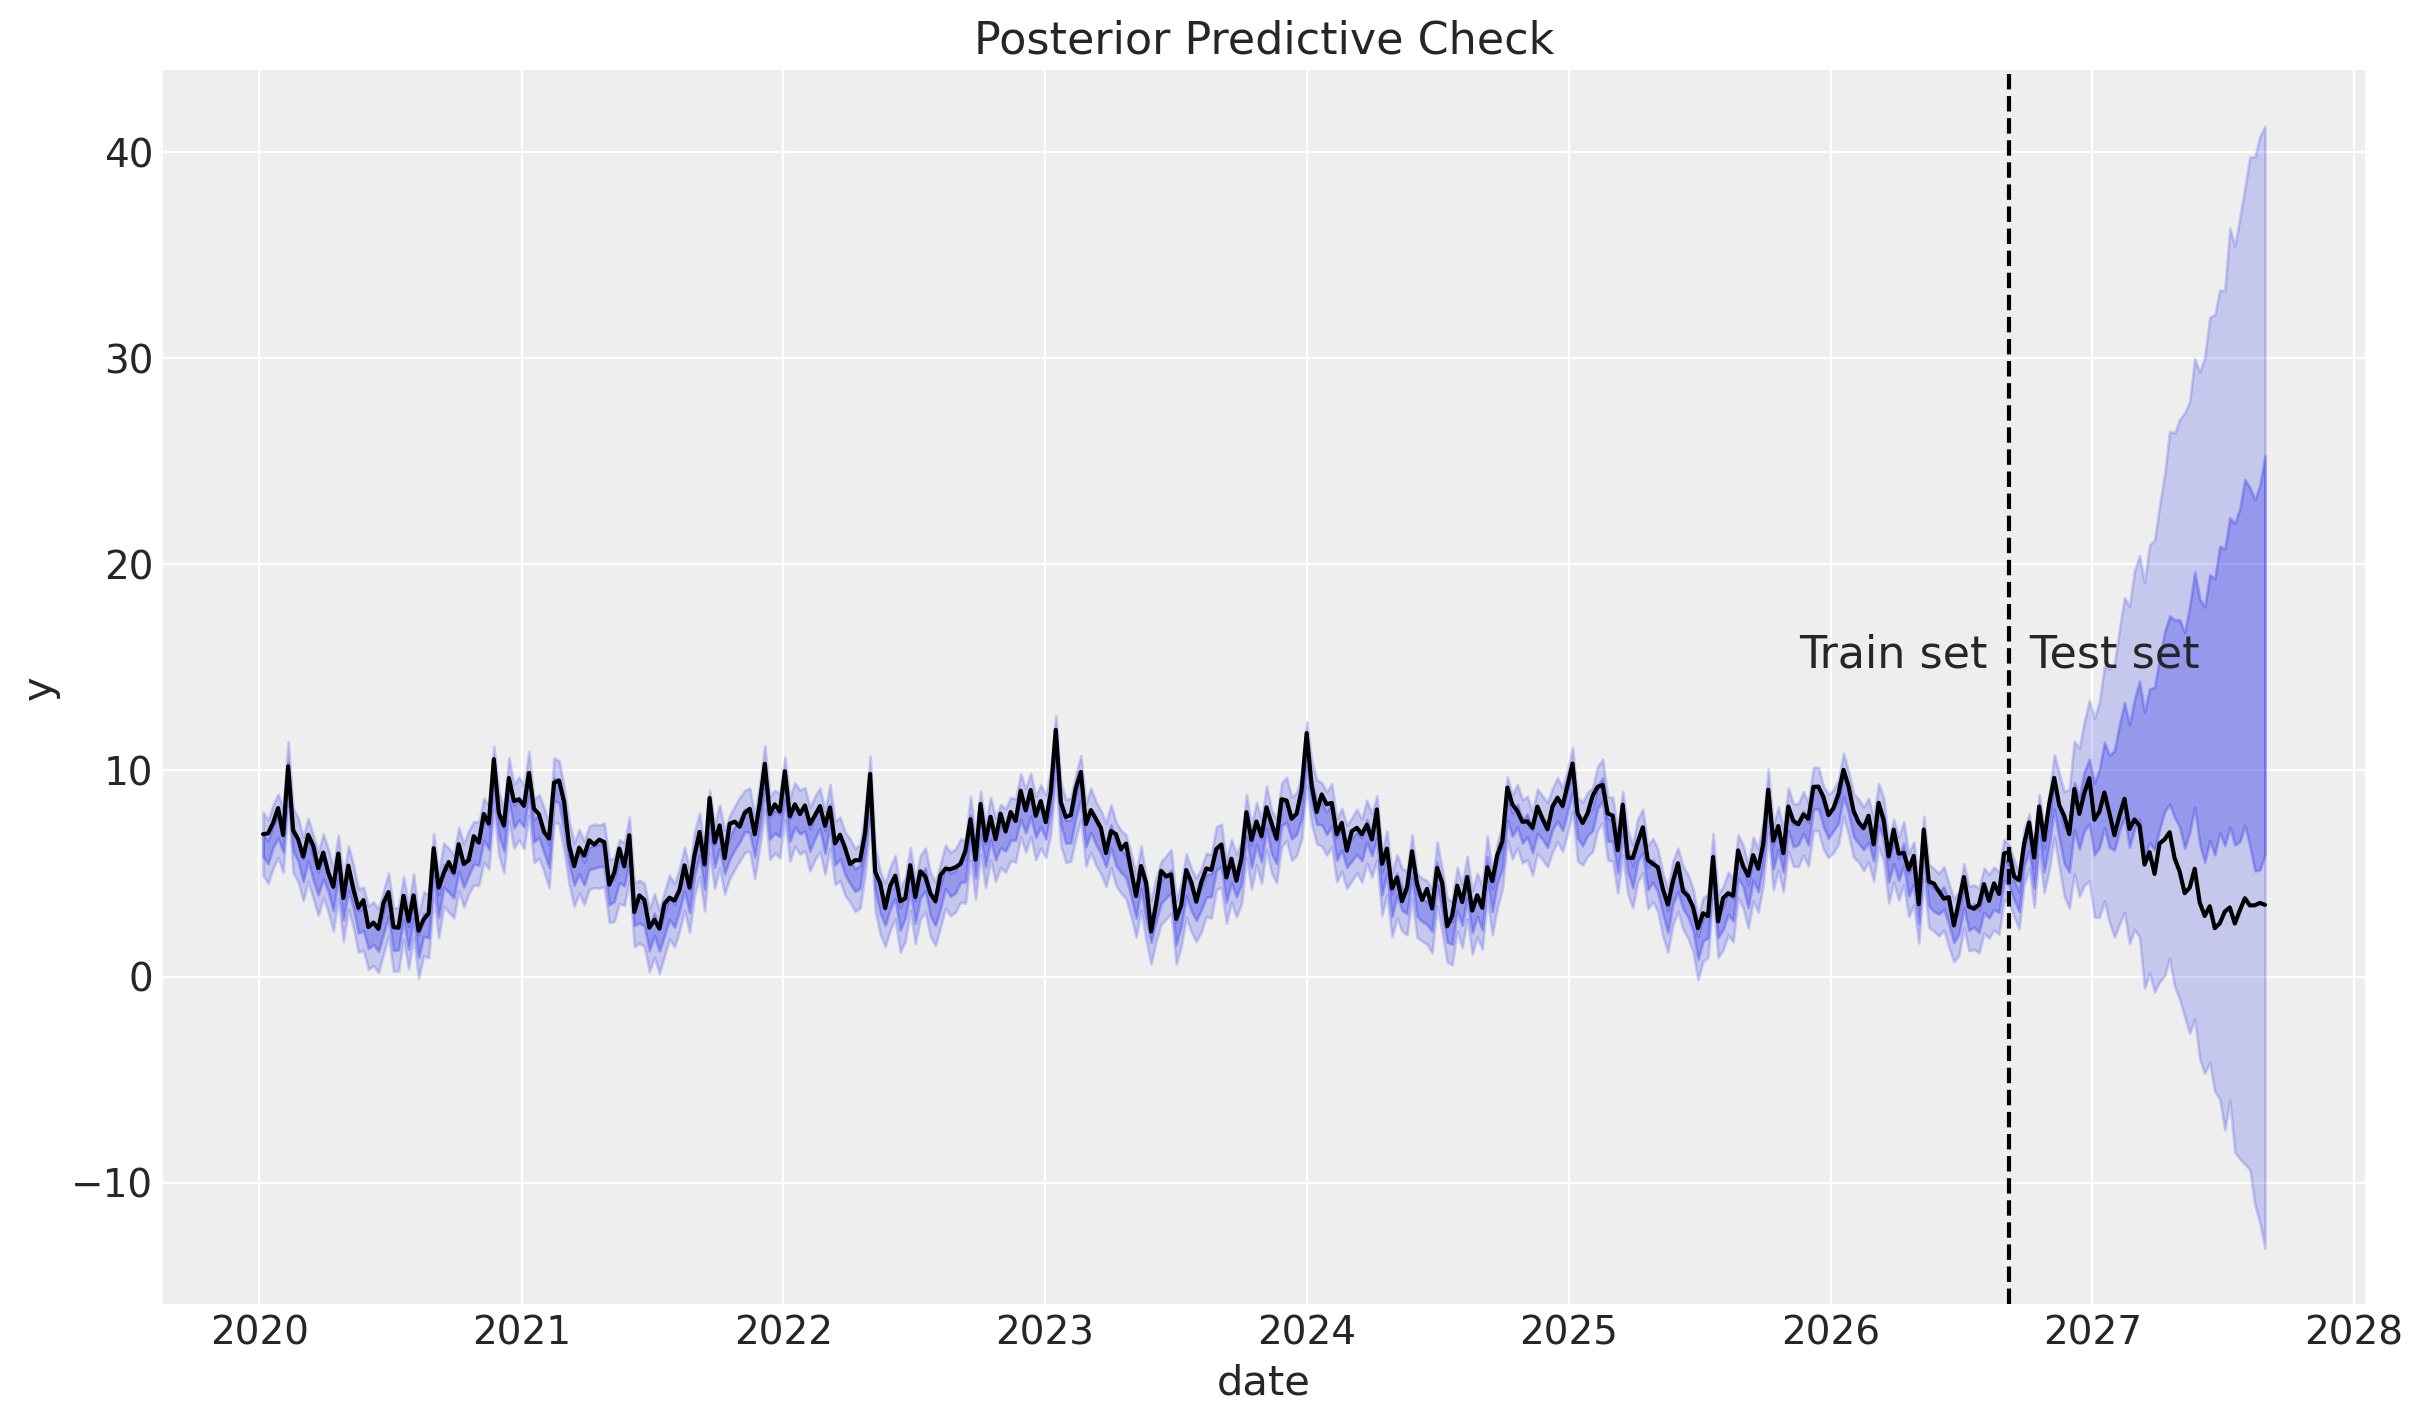

In [10]:
# Sample posterior predictive in whole data range (train and test)
mmm1.sample_posterior_predictive(X_pred=data, extend_idata=True, var_names=["y", "intercept"])
mmm1.y = data["target1"].values

# Plot the posterior predictive
fig, ax = plt.subplots()
mmm1.plot_posterior_predictive(original_scale=True, ax=ax)
ax.axvline(
    mmm1.posterior_predictive.date[data_train.shape[0]].values,
    color="black",
    linestyle="--",
)
ax.text(
    mmm1.posterior_predictive.date[data_train.shape[0]].values - int(14 * 864000e8),
    mmm1.target_transformer.inverse_transform([[np.percentile(mmm1.posterior_predictive.y, 97.5)]])[0][0],
    "Train set   Test set",
    verticalalignment="center",
    horizontalalignment="center",
    fontsize=16,
)
plt.show()

**Predicting intercept**

But how well does it predict the actual time-varying factor? Well, it's definitely not perfect, but GPs are tricky :).

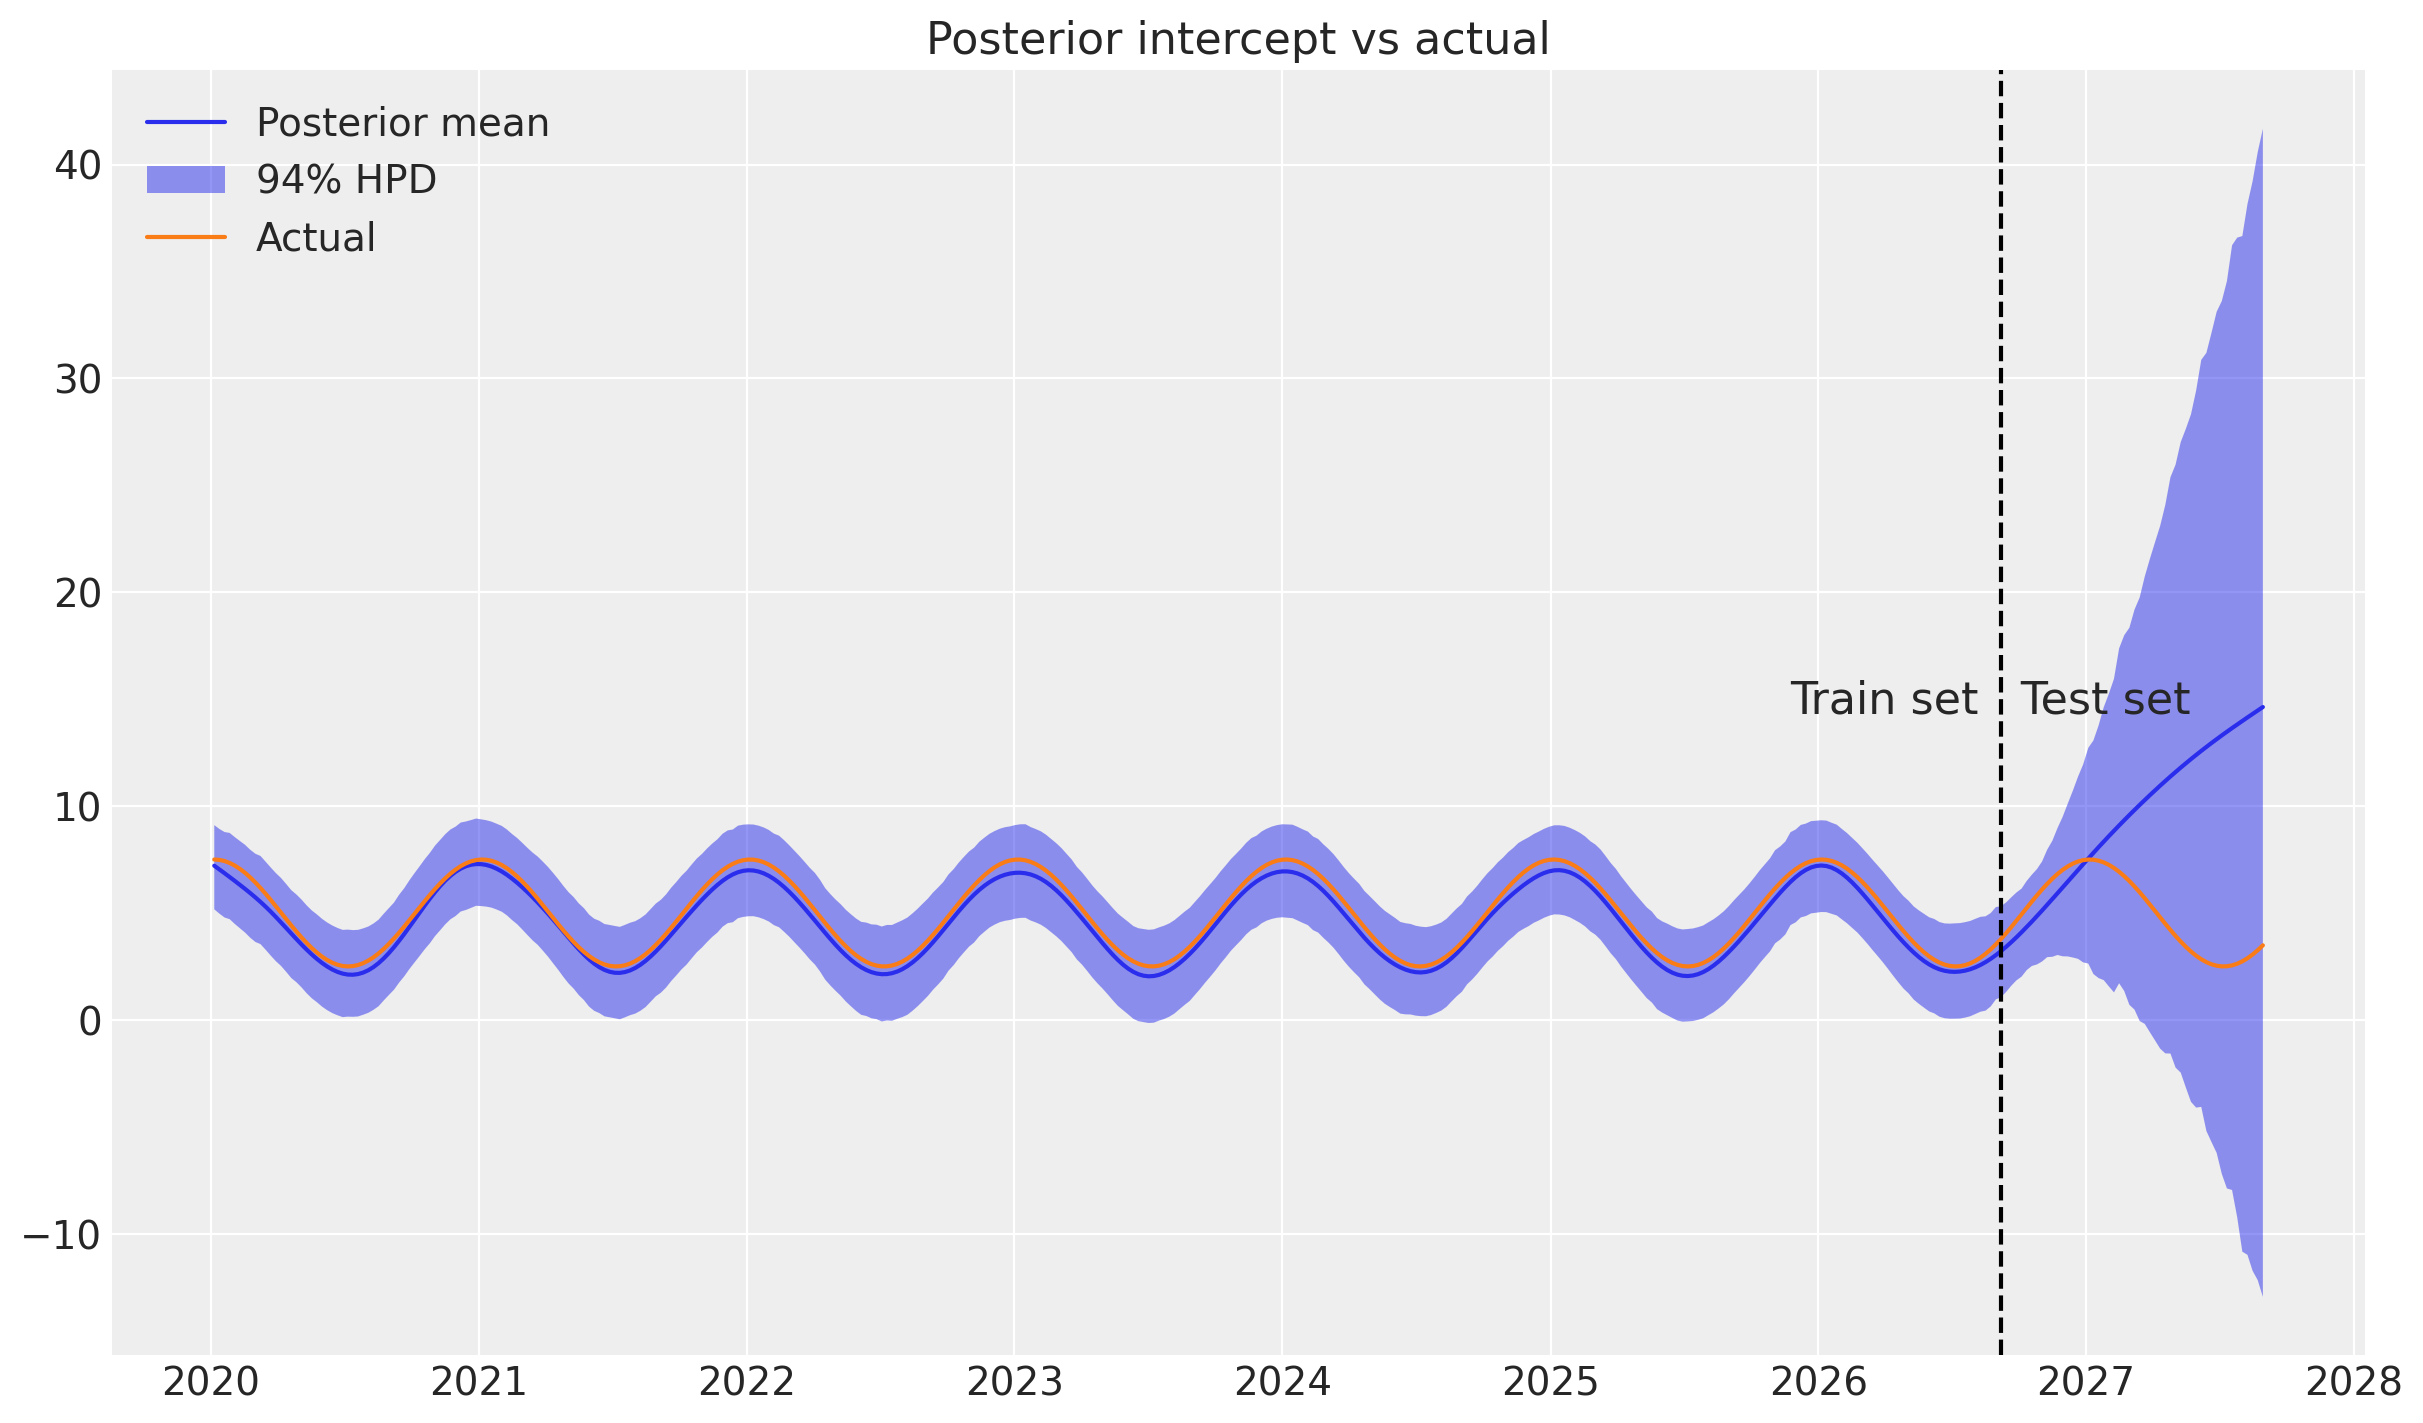

In [11]:
# Get the posterior predictive of intercept
intercept_posterior_mean = mmm1.target_transformer.inverse_transform(
    mmm1.posterior_predictive.intercept.mean(axis=(0, 1)).data[:, None]
)
intercept_posterior_hpd = mmm1.target_transformer.inverse_transform(
    az.hdi(mmm1.posterior_predictive.intercept.values, hdi_prob=0.94)
)

# Plot posterior intercept versus actual
fig, ax = plt.subplots()
ax.set_title("Posterior intercept vs actual")
ax.plot(mmm1.posterior_predictive.date, intercept_posterior_mean, label="Posterior mean")
ax.fill_between(
    mmm1.posterior_predictive.date,
    intercept_posterior_hpd[:, 0],
    intercept_posterior_hpd[:, 1],
    alpha=0.5,
    label="94% HPD",
)
ax.plot(mmm1.posterior_predictive.date, true_intercept, label="Actual")
ax.axvline(
    mmm1.posterior_predictive.date[data_train.shape[0]].values,
    color="black",
    linestyle="--",
)
ax.text(
    mmm1.posterior_predictive.date[data_train.shape[0]].values - int(14 * 864000e8),
    mmm1.target_transformer.inverse_transform([[np.percentile(mmm1.posterior_predictive.intercept, 97.5)]])[0][0],
    "Train set   Test set",
    verticalalignment="center",
    horizontalalignment="center",
    fontsize=16,
)
ax.legend()
plt.show()

The synthetic intercept had mean 5. Since the time varying multiplier is centered to have mean 1, the fitted baseline intercept should be close to 5.

In [12]:
print(
    "intercept_base:",
    float(
        mmm1.idata.posterior.intercept_base.mean()
        * mmm1.target_transformer.steps[0][1].scale_[0]
    ),
)

intercept_base: 5.1778783426686275


While the time varying multiplier should have a mean of 1.

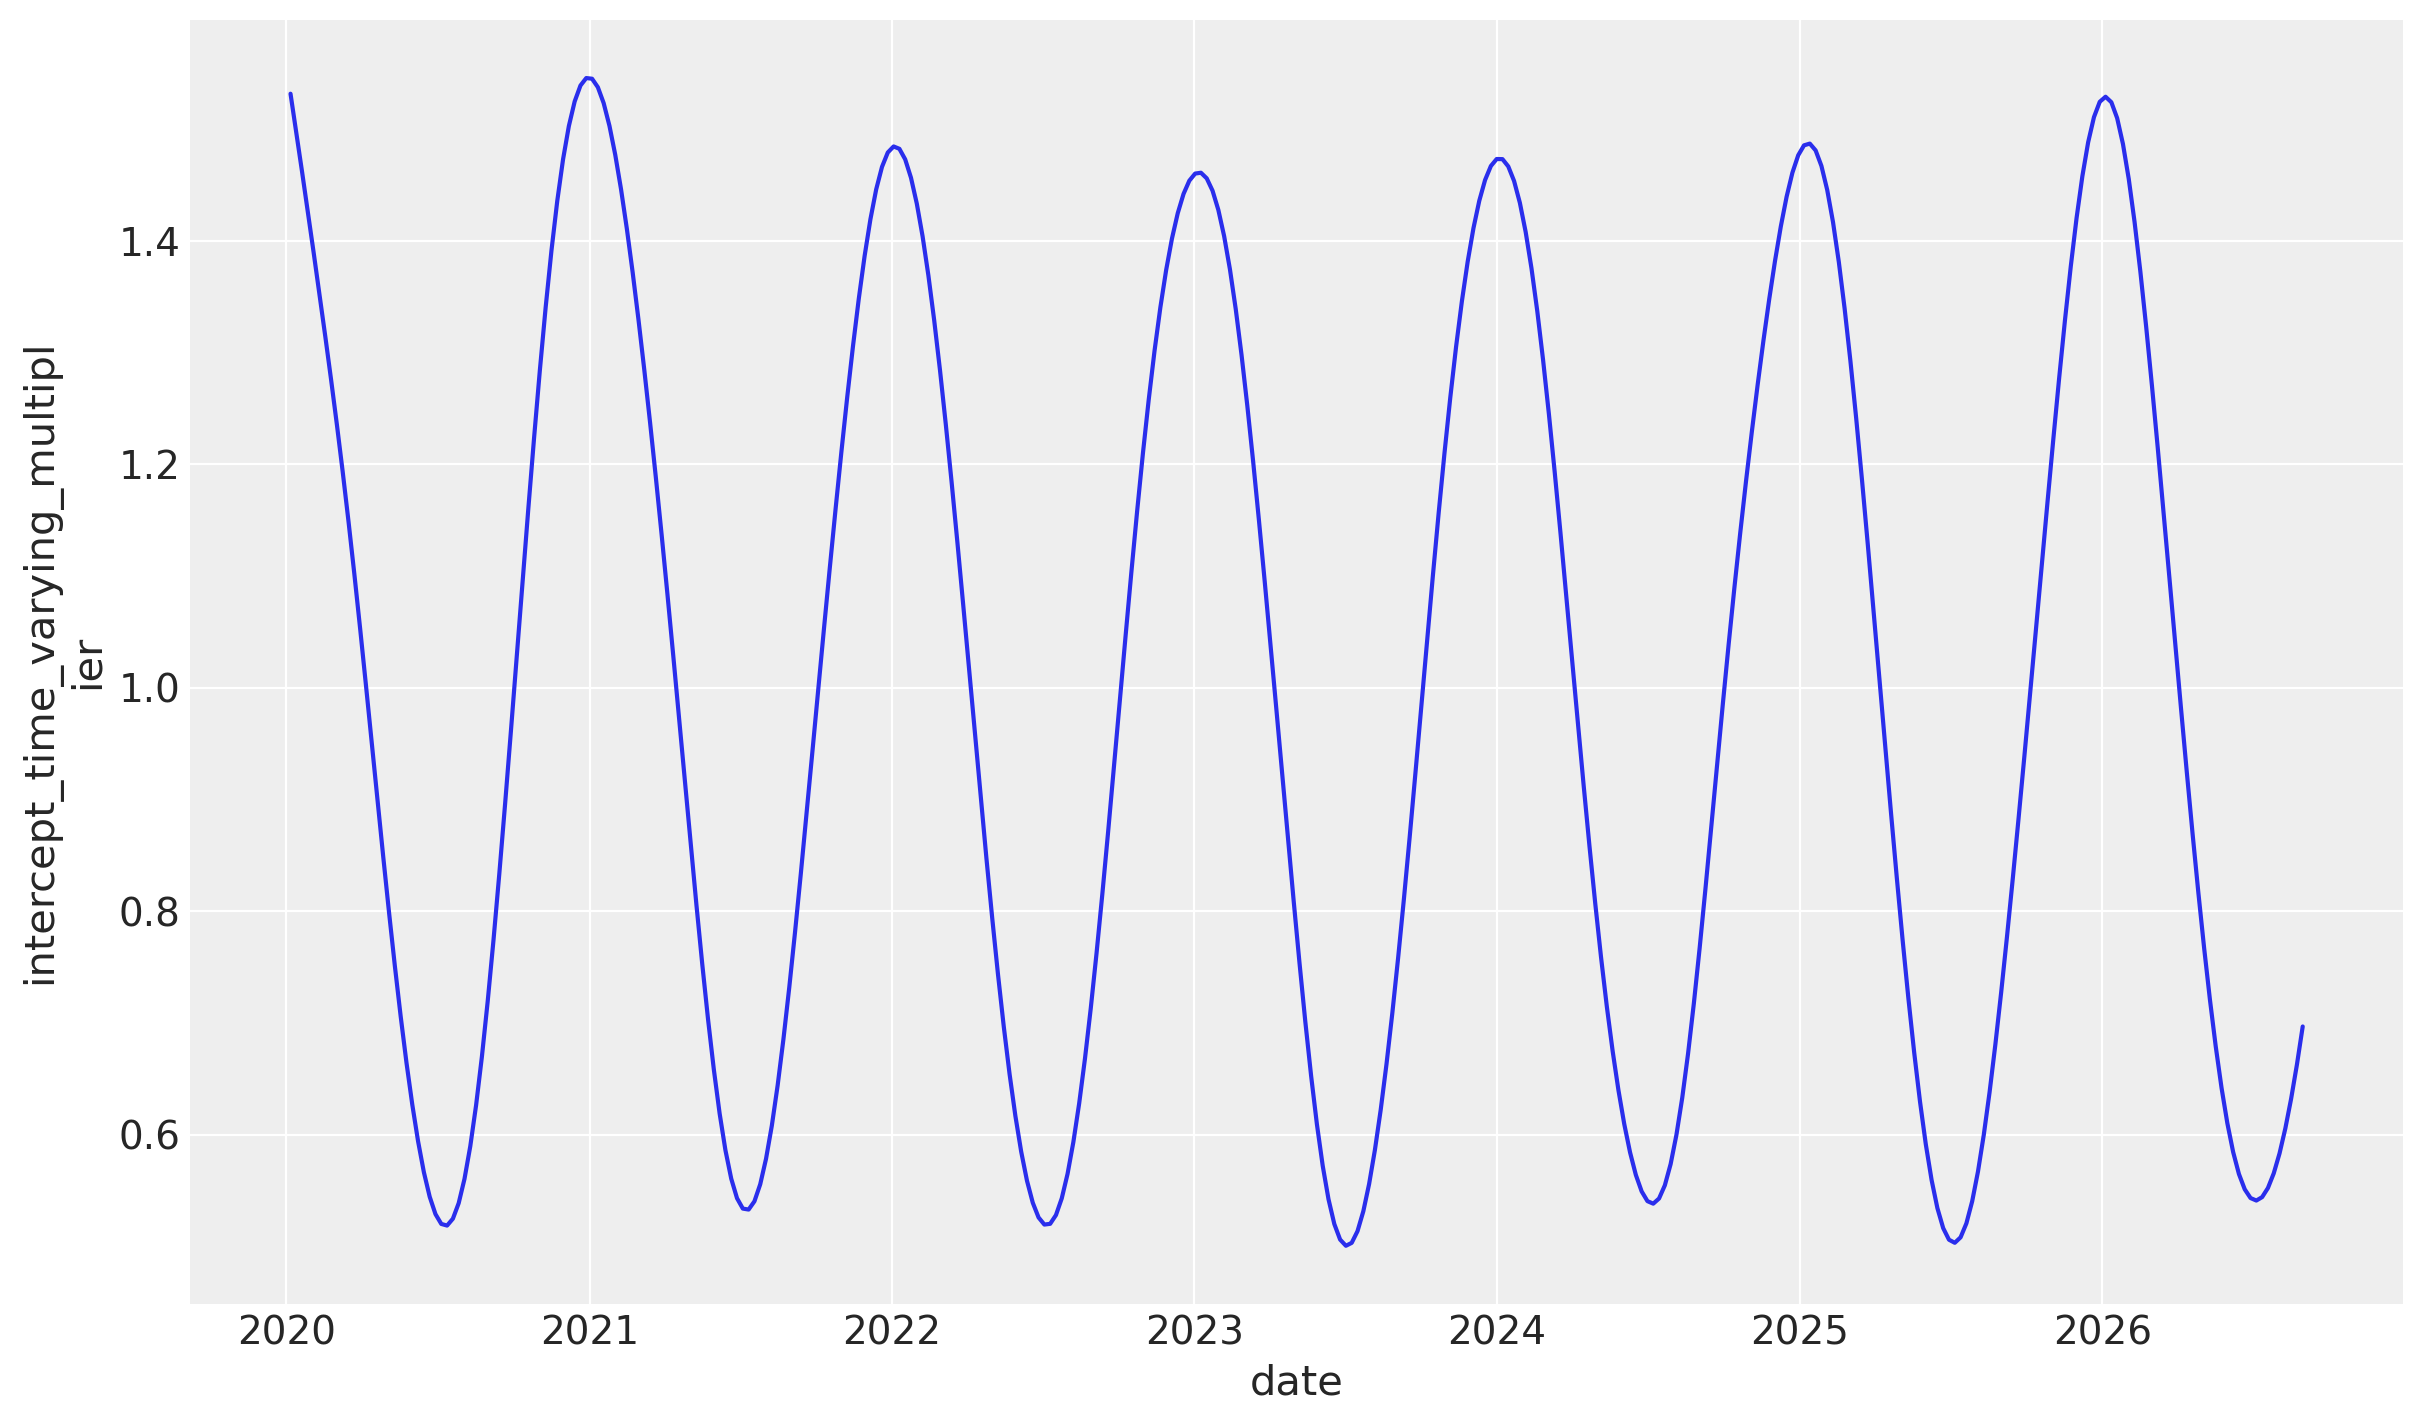

In [13]:
mmm1.idata.posterior.intercept_time_varying_multiplier.mean(axis=(0, 1)).plot()

## 2. Trending intercept

#### → Simulate a target (e.g. sales)

Repeating the procedure from "1. Seasonal intercept" but with a linearly increasing intercept.

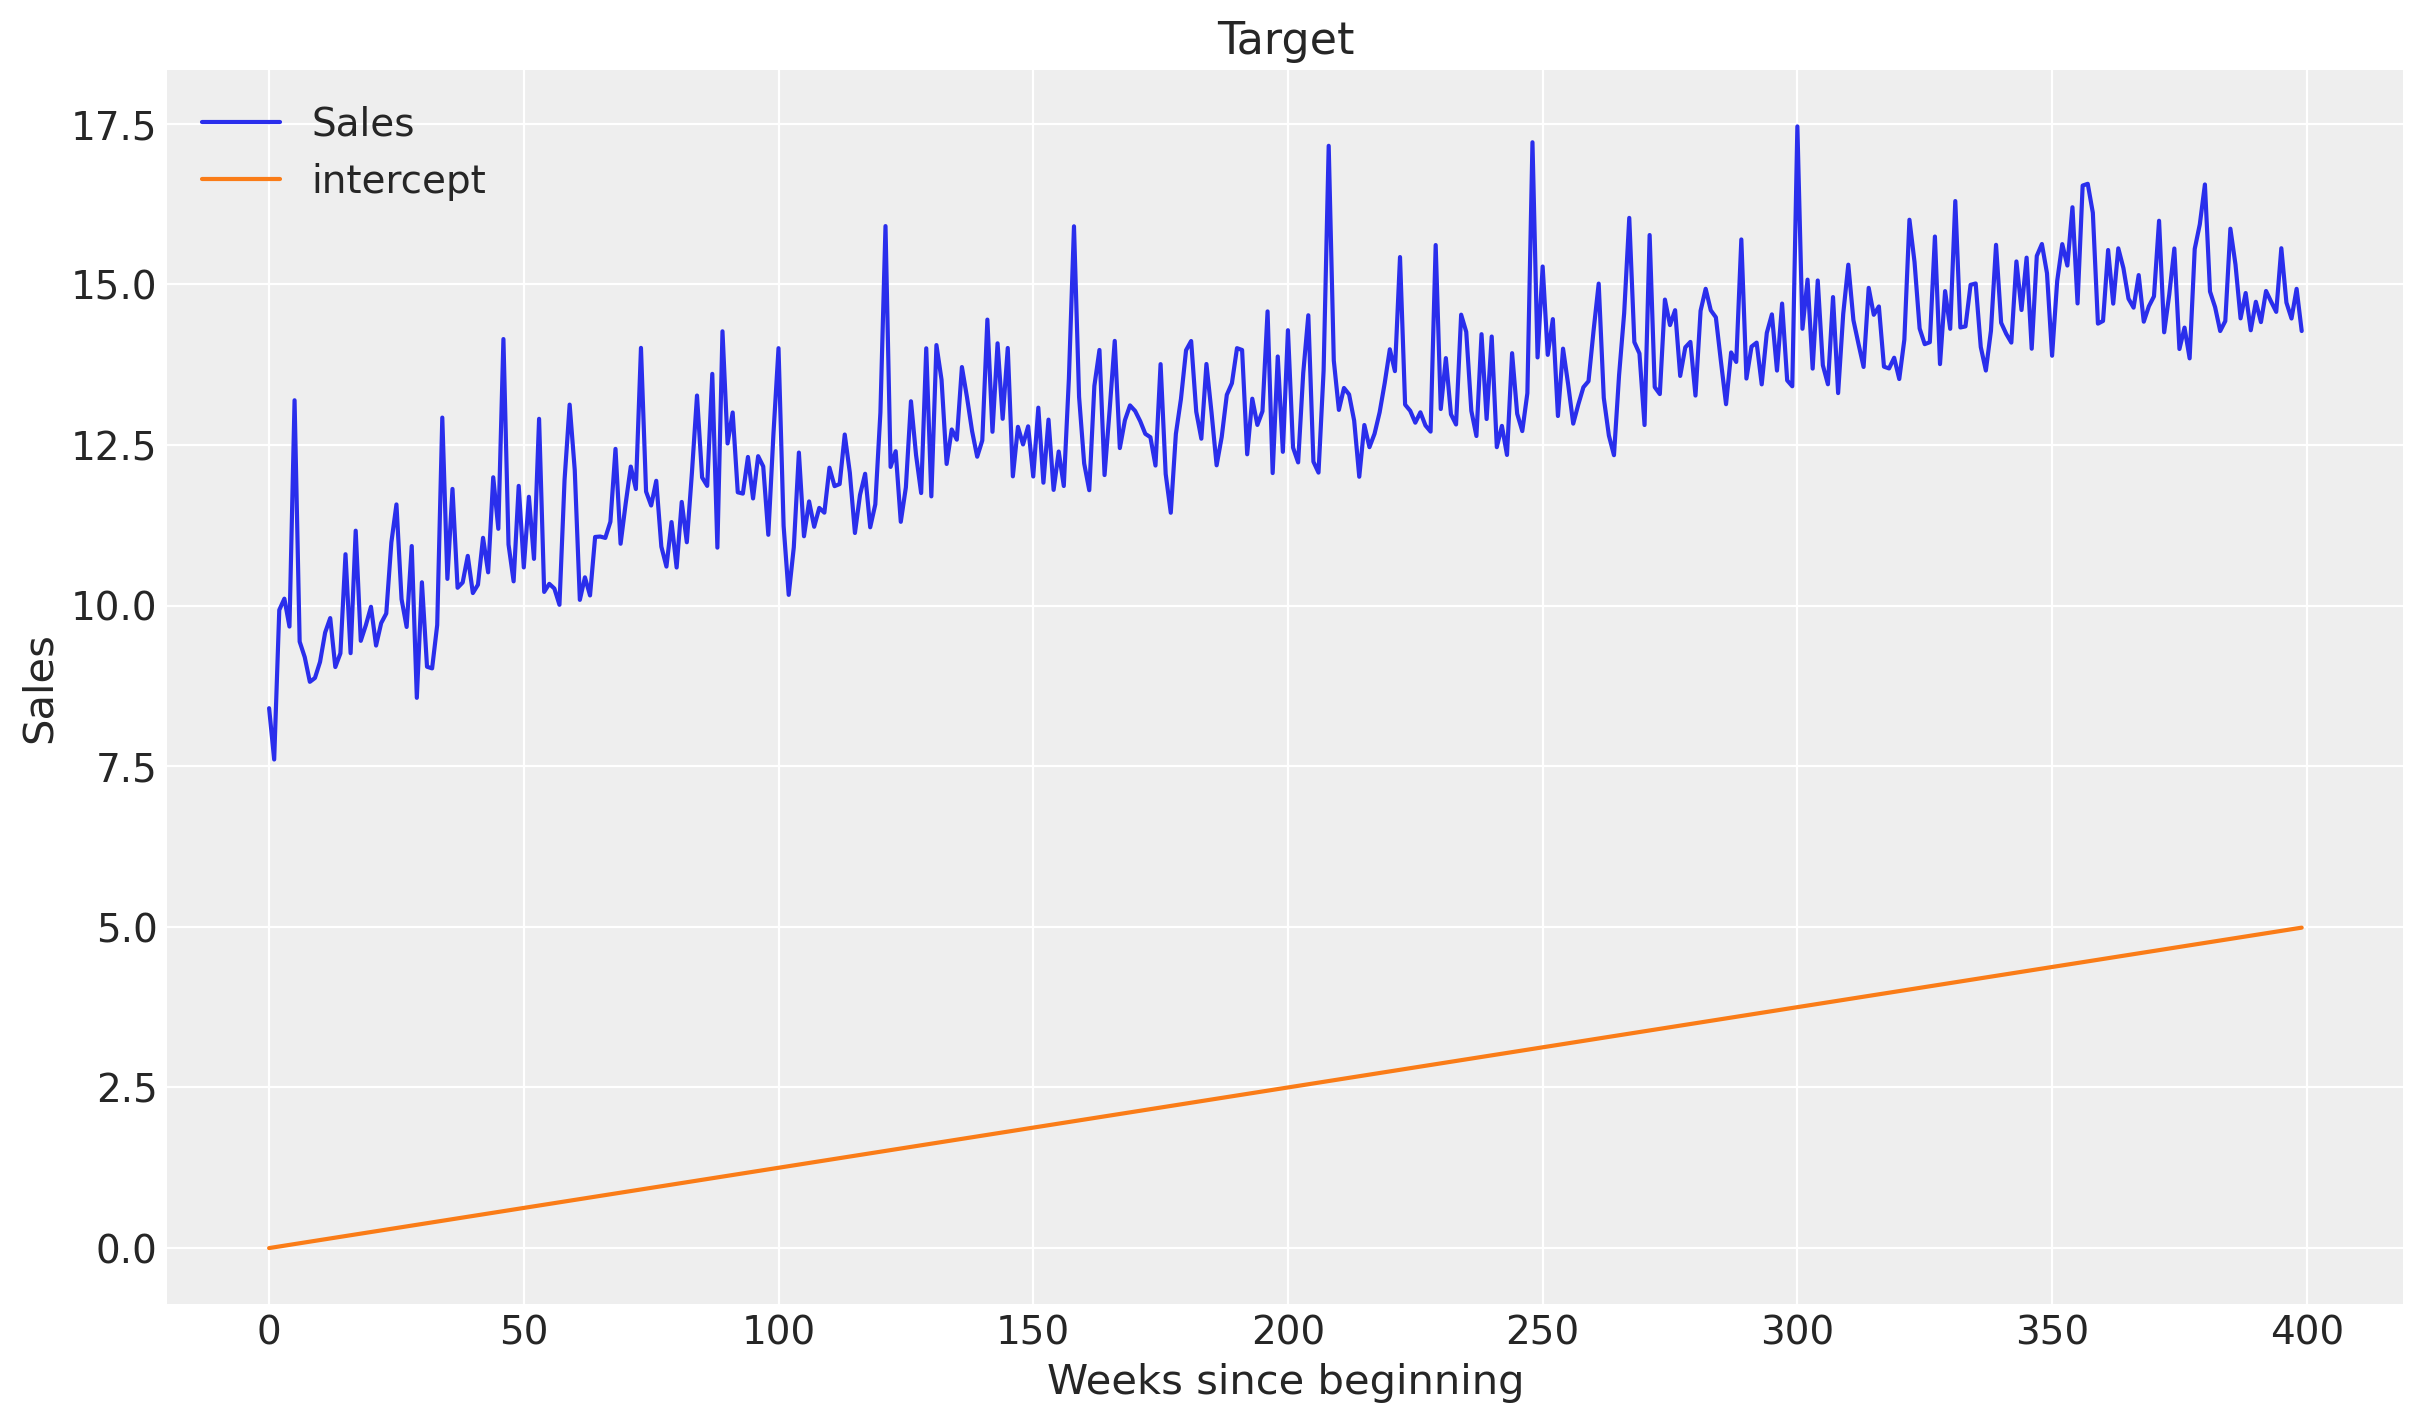

In [14]:
# Create the model
mmm_synth2 = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=coords["media"],
    control_columns=coords["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
)

mmm_synth2.build_model(data, np.ones(data.shape[0]))

# Define the true parameters of the model
N = np.arange(data.shape[0])
true_intercept = np.arange(data.shape[0]) / data.shape[0] * 5
true_params = {
    "intercept": true_intercept,
    "beta_channel": np.array([3.5, 2.0, 5.0, 3.2, 1.5, 2.0, 1.0, 1.5]) * 4,
    "alpha": np.array([0, 0.5, 0.1, 0.1, 0.9, 0.5, 0.9, 0.95]),
    "lam": 1 / (data[coords["media"]].mean(0)).values,
    "likelihood_sigma": 0.25,
}

# Manually set the model parameters
true_model2 = pm.do(
    mmm_synth2.model,
    true_params,
)

# Plot the simulated target series
fig, ax = plt.subplots()
ax.set_title("Target")
np.random.seed(0)
data["target2"] = pm.draw(true_model2.y)
data["target2"].plot(xlabel="Weeks since beginning", ylabel="Sales", label="Sales")
ax.plot(true_intercept, label="intercept")
ax.legend()
plt.show()

#### → Split into train and test
We split the data into *train* and *test* sets, so that we can later display out-of-sample predictive performance.

In [15]:
# Split into train and test
data_train = data.iloc[:-52]
data_test = data.iloc[-52:]

## Fit a DelayedSaturatedMMM with TVP

#### → Fit the model

In [16]:
mmm2 = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=coords["media"],
    control_columns=coords["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
    sampler_config={
        "chains": 4,
        "draws": 4000,
        "tune": 1000,
        "nuts_sampler": "numpyro",
    },
)
mmm2.fit(data_train, data_train["target2"])

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

#### → Posterior predictive check

**Predicting sales**

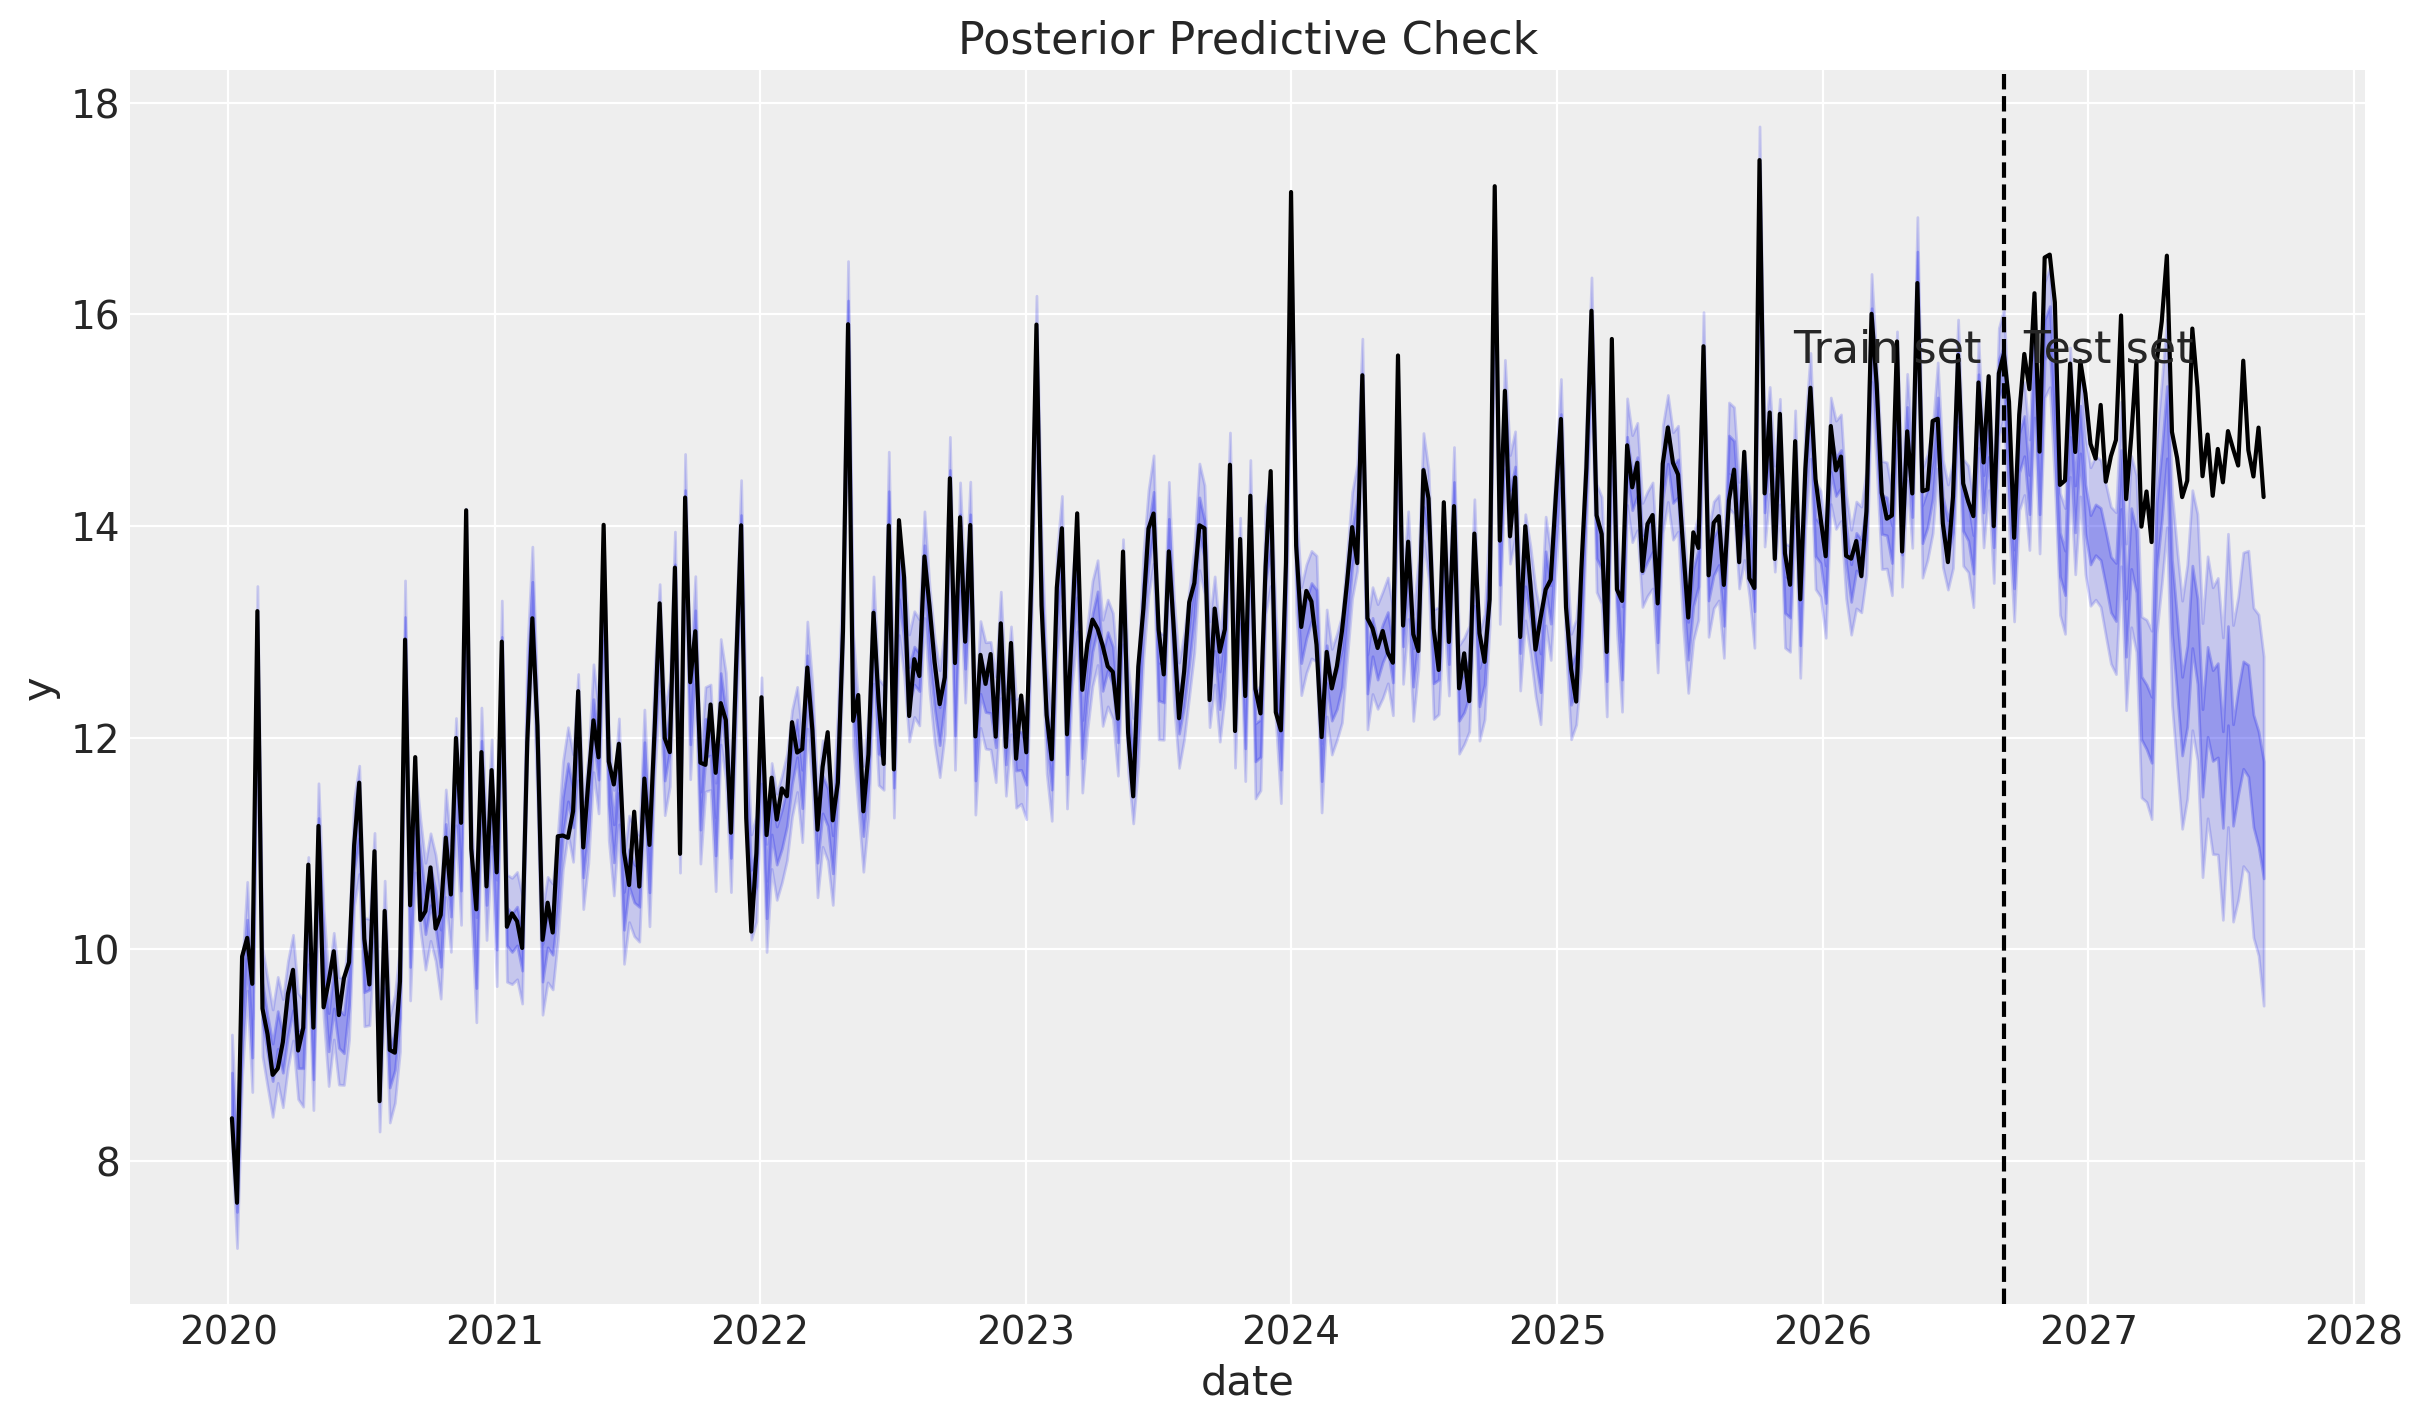

In [29]:
# Sample posterior predictive in whole data range (train and test)
mmm2.sample_posterior_predictive(X_pred=data, extend_idata=True, var_names=["y", "intercept"])
mmm2.y = data["target2"].values

# Plot the posterior predictive
fig, ax = plt.subplots()
mmm2.plot_posterior_predictive(original_scale=True, ax=ax)
ax.axvline(
    mmm2.posterior_predictive.date[data_train.shape[0]].values,
    color="black",
    linestyle="--",
)
ax.text(
    mmm2.posterior_predictive.date[data_train.shape[0]].values - int(14 * 864000e8),
    mmm2.target_transformer.inverse_transform([[np.percentile(mmm2.posterior_predictive.y, 97.5)]])[0][0],
    "Train set   Test set",
    verticalalignment="center",
    horizontalalignment="center",
    fontsize=16,
)

plt.show()

**Predicting intercept**

It's clear that, out-of-sample, the HSGP reverts the its prior. Note, though, that for the first few months it predicts well.

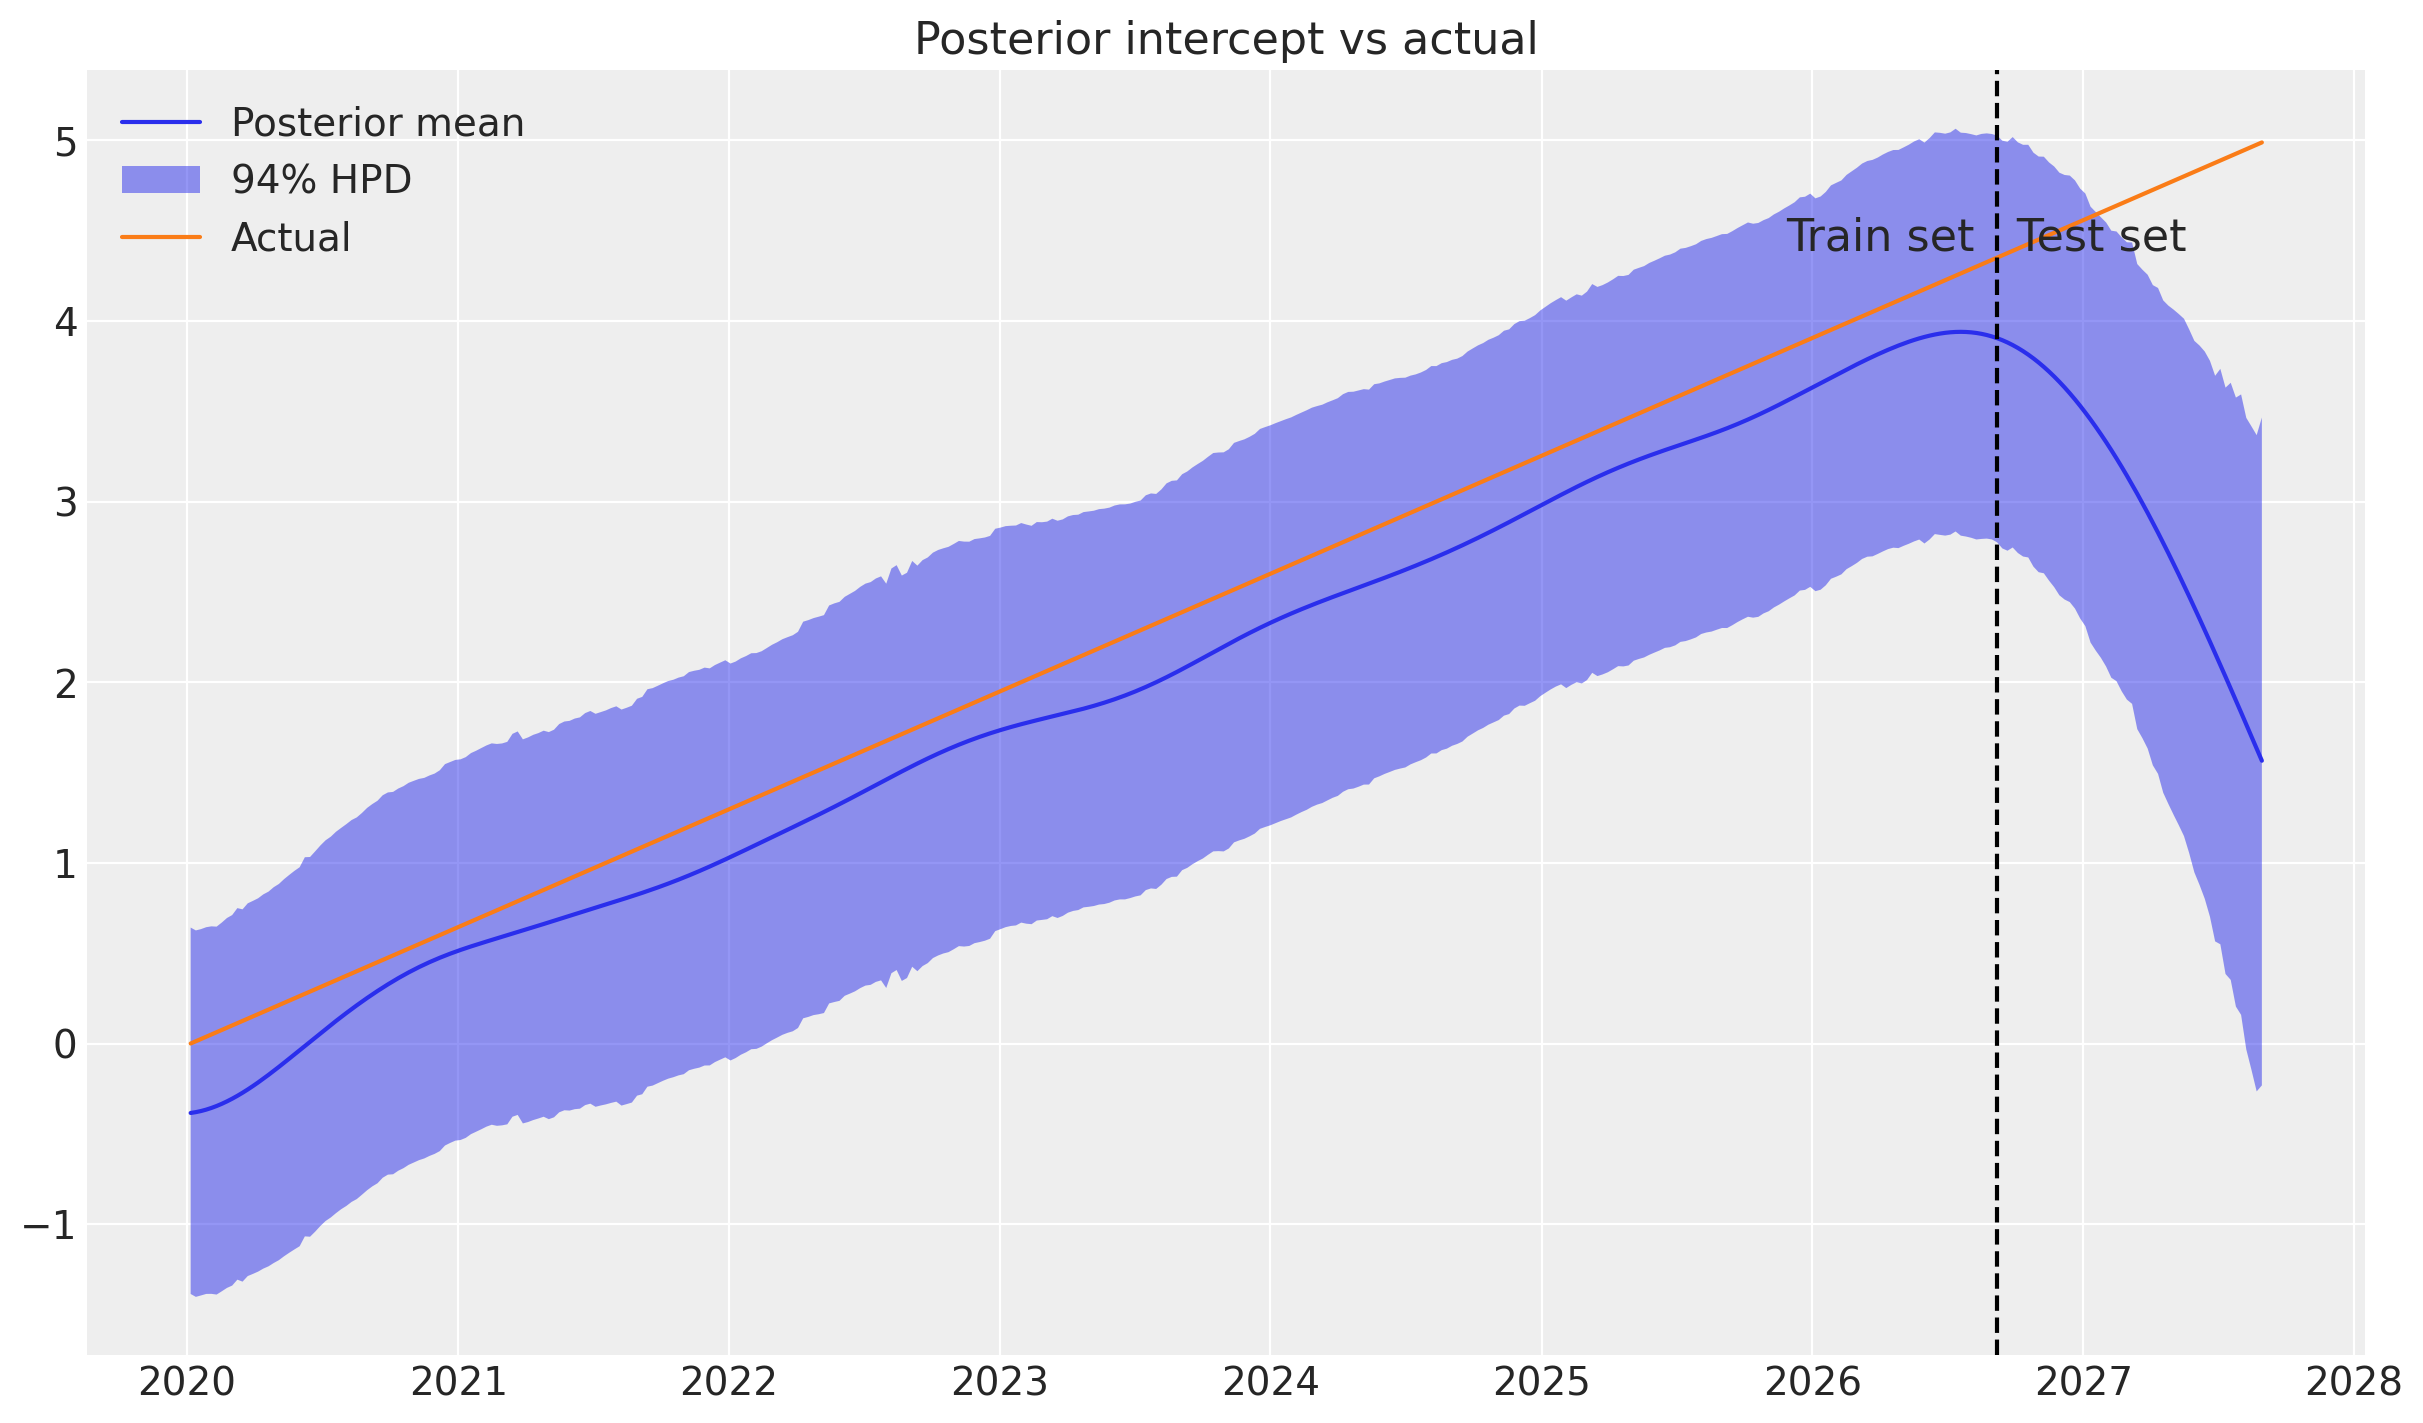

In [18]:
# Get the posterior predictive of intercept
intercept_posterior_mean = mmm2.target_transformer.inverse_transform(
    mmm2.posterior_predictive.intercept.mean(axis=(0, 1)).data[:, None]
)
intercept_posterior_hpd = mmm2.target_transformer.inverse_transform(
    az.hdi(mmm2.posterior_predictive.intercept.values, hdi_prob=0.94)
)

# Plot posterior intercept versus actual
fig, ax = plt.subplots()
ax.set_title("Posterior intercept vs actual")
ax.plot(mmm2.posterior_predictive.date, intercept_posterior_mean, label="Posterior mean")
ax.fill_between(
    mmm2.posterior_predictive.date,
    intercept_posterior_hpd[:, 0],
    intercept_posterior_hpd[:, 1],
    alpha=0.5,
    label="94% HPD",
)
ax.plot(mmm2.posterior_predictive.date, true_intercept, label="Actual")
ax.axvline(
    mmm2.posterior_predictive.date[data_train.shape[0]].values,
    color="black",
    linestyle="--",
)
ax.text(
    mmm2.posterior_predictive.date[data_train.shape[0]].values - int(14 * 864000e8),
    mmm2.target_transformer.inverse_transform([[np.percentile(mmm2.posterior_predictive.intercept, 97.5)]])[0][0],
    "Train set   Test set",
    verticalalignment="center",
    horizontalalignment="center",
    fontsize=16,
)
ax.legend()
plt.show()

The synthetic intercept had mean 2.5. Since the time varying multiplier is centered to have mean 1, the fitted baseline intercept should be close to 2.5.

In [19]:
print(
    "intercept_base:",
    float(
        mmm2.idata.posterior.intercept_base.mean()
        * mmm2.target_transformer.steps[0][1].scale_[0]
    ),
)

intercept_base: 2.0467452016364733


While the time varying multiplier should have a mean of 1.

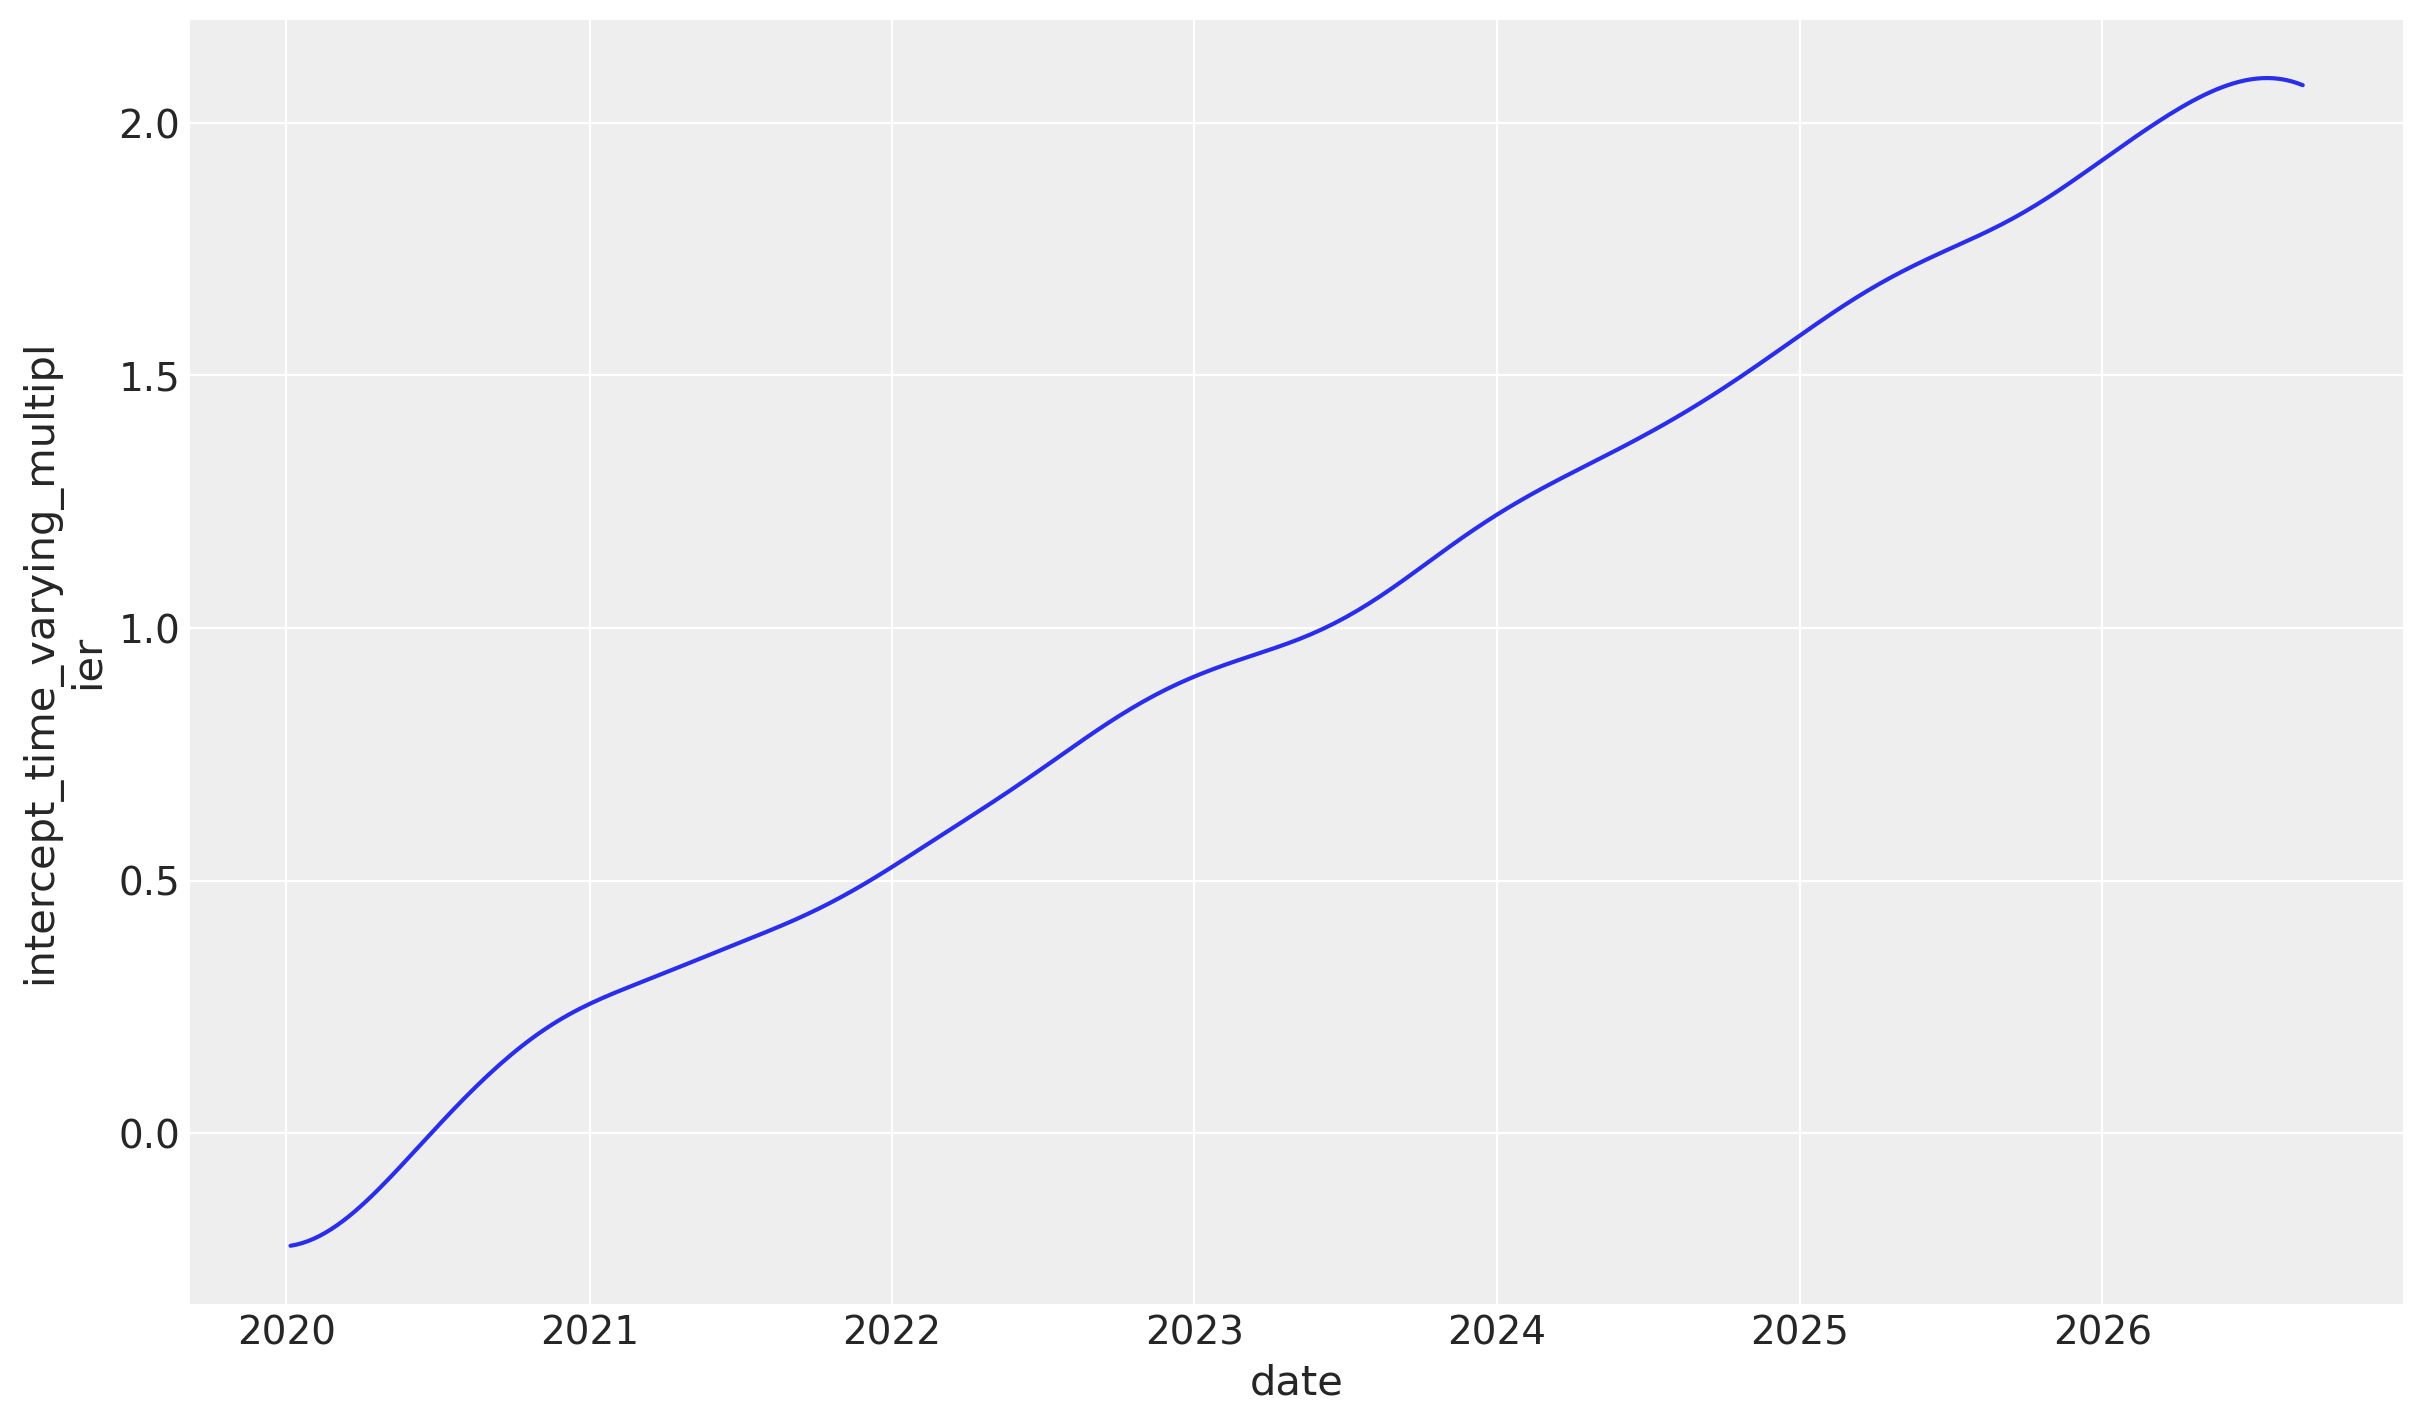

In [30]:
mmm2.idata.posterior.intercept_time_varying_multiplier.mean(axis=(0, 1)).plot()